## MORE CLEANING/PREPROCESSING

In [379]:
import pandas as pd
import numpy as np

import re
import string

import nltk
from nltk.corpus import stopwords
import spacy

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [392]:
df = pd.read_pickle("./df_project 5.pkl")
df

,index,AUTHOR,COMPOSER,DATE,LYRICS,ORCHESTRA,SINGER,TITLE,TYPE,WORDS
0,0,Julio César Curi,Edmundo Baya,1960,Tristeza... Con el vino de mi mesa Desataste u...,Rodolfo BIAGI,Hugo Duval,"[Te, burlas, tristeza]",TANGO,124
1,4,Alejandro Romay,Roberto Rufino,1959,"La casita sobre el lago azul, el nido y luz de...",Rodolfo BIAGI,Hugo Duval,"[En, el, lago, azul]",TANGO,80
2,6,Lito Bayardo,Juan de Dios Filiberto,1959,"Flor de mburucuyá, Abre tu balcón Para mi cant...",Rodolfo BIAGI,Hugo Duval,"[La, canción]",TANGO,83
3,7,Oscar Rubens,Alberto Suárez Villanueva,1945,"Tu melodía siempre la escucho, Y donde vaya, m...",Rodolfo BIAGI,Jorge Ortiz,"[Tu, melodía]",VALS,78
4,8,Alberto Vacarezza,Raúl de los Hoyos,1956,"Chiche Moro Zaino Vamos, pingos, por fav...",Rodolfo BIAGI,Hugo Duval,"[El, carrerito]",TANGO,159
...,...,...,...,...,...,...,...,...,...,...
2466,12201,José Panizza,Edgardo Donato,1959,Yo tenía un amorcito que me dejó abandonada y ...,Osvaldo FRESEDO,Blanca Mooney,[Julian],TANGO,171
2467,13225,Miguel Andrés Fama,Miguel Andrés Fama,1939,"Sos la milonga linda Cadenciosa, rezongona, So...",Edgardo DONATO,Horacio Lagos,"[La, mimada]",MILONGA,74
2468,13270,Enrique Dizeo,Anselmo Aieta,1950,"Qué tipo de suerte que sos, mama mía Siempre...",Edgardo DONATO,Carlos Almada,"[Qué, fenómeno]",TANGO,152
2469,13284,Alberto Laureano Martínez,Enrique Santos Discépolo,1960,"Todo duele en la noche de mi soledad, Duele ve...",Domingo FEDERICO,Ruben Sanchez y Ruben Maciel,[Andrajos],TANGO,110


In [393]:
#removing all capital letters
df.LYRICS = df.LYRICS.str.lower()

In [394]:
#removing punctuation
df.LYRICS = df.LYRICS.map(lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x))

In [395]:
#downloading spanish stopwords
nltk.download('stopwords')
stops = set(stopwords.words('spanish'))
#print(stops)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/krystiankrystkowiak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [396]:
#using spacy for lemma

en_core = spacy.load('es_core_news_lg')

In [397]:
df["lemmatized"] = df['LYRICS'].apply(lambda x: " ".join([y.lemma_ for y in en_core(x)]))

In [398]:
df.drop(['index'], axis=1, inplace=True)
df

,AUTHOR,COMPOSER,DATE,LYRICS,ORCHESTRA,SINGER,TITLE,TYPE,WORDS,lemmatized
0,Julio César Curi,Edmundo Baya,1960,tristeza con el vino de mi mesa desataste u...,Rodolfo BIAGI,Hugo Duval,"[Te, burlas, tristeza]",TANGO,124,tristeza con el vino de mi mesa desataste ...
1,Alejandro Romay,Roberto Rufino,1959,la casita sobre el lago azul el nido y luz de...,Rodolfo BIAGI,Hugo Duval,"[En, el, lago, azul]",TANGO,80,el casita sobre el lago azul el nido y luz d...
2,Lito Bayardo,Juan de Dios Filiberto,1959,flor de mburucuyá abre tu balcón para mi cant...,Rodolfo BIAGI,Hugo Duval,"[La, canción]",TANGO,83,flor de mburucuyá abrir tu balcón para mi ca...
3,Oscar Rubens,Alberto Suárez Villanueva,1945,tu melodía siempre la escucho y donde vaya m...,Rodolfo BIAGI,Jorge Ortiz,"[Tu, melodía]",VALS,78,tu melodía siempre él escuchar y donde ir ...
4,Alberto Vacarezza,Raúl de los Hoyos,1956,chiche moro zaino vamos pingos por fav...,Rodolfo BIAGI,Hugo Duval,"[El, carrerito]",TANGO,159,chiche moro zaino ir pingo por f...
...,...,...,...,...,...,...,...,...,...,...
2466,José Panizza,Edgardo Donato,1959,yo tenía un amorcito que me dejó abandonada y ...,Osvaldo FRESEDO,Blanca Mooney,[Julian],TANGO,171,yo tener uno amorcito que yo dejar abandonado ...
2467,Miguel Andrés Fama,Miguel Andrés Fama,1939,sos la milonga linda cadenciosa rezongona so...,Edgardo DONATO,Horacio Lagos,"[La, mimada]",MILONGA,74,sos el milonga lindo cadenciós rezongona s...
2468,Enrique Dizeo,Anselmo Aieta,1950,qué tipo de suerte que sos mama mía siempre...,Edgardo DONATO,Carlos Almada,"[Qué, fenómeno]",TANGO,152,qué tipo de suerte que sos mama mío siem...
2469,Alberto Laureano Martínez,Enrique Santos Discépolo,1960,todo duele en la noche de mi soledad duele ve...,Domingo FEDERICO,Ruben Sanchez y Ruben Maciel,[Andrajos],TANGO,110,todo doler en el noche de mi soledad doler v...


In [241]:
#tuning stopwords set
custom_stops = ['12', '13', '1910', '1e', '24telefoneá', '33', '80',
                '900cruzó', '900que', '911ya', '920', 'ser', 'ir', 'hacer', 'vo', 'haber', 'querer', 'ver', 'saber', 'tener', 'oh', 'si', 'pa', 'vos', 'aquel', 'ay',  'sos', 'así', 'bien']
stops.update(custom_stops)
#print(stops)

In [242]:
#creating corpus
corpus = list(df["lemmatized"])

# LSA (svd)

In [331]:
number_of_topics = 3

In [332]:
vectorizer = CountVectorizer(stop_words = stops,
                     min_df = .0042,
                     ngram_range = (1,1))

doc_term = vectorizer.fit_transform(corpus)

In [333]:
#doc_term_df = pd.DataFrame(doc_term.toarray(), index=corpus, columns=vectorizer.get_feature_names_out())

In [334]:
lsa = TruncatedSVD(number_of_topics)
lsa.fit(doc_term)

TruncatedSVD(n_components=3)

In [335]:
lsa.explained_variance_ratio_

array([0.02086351, 0.02461464, 0.01897426])

In [336]:
topic_term = lsa.components_.round(3)

In [337]:
topic_term_df = pd.DataFrame(topic_term.round(3),
#             index = ["component_1","component_2", "component_3", "component_4", "component_5"],
             columns = vectorizer.get_feature_names_out())

In [338]:
topic_term_df

,abajo,abandonado,abandonar,abandono,abierto,abismo,abrazado,abrazar,abrazo,abrigar,...,yuyo,zaguán,zapato,zorro,zorzal,zurda,ángel,árbol,último,único
0,0.003,0.005,0.007,0.004,0.004,0.006,0.002,0.005,0.005,0.001,...,0.002,0.001,0.002,0.002,0.004,0.001,0.004,0.002,0.013,0.006
1,0.001,0.002,-0.000,-0.002,0.002,-0.002,0.000,-0.001,0.005,0.000,...,0.004,0.002,0.001,0.005,0.002,0.003,-0.002,0.002,0.011,-0.000
2,-0.005,-0.003,-0.002,-0.002,-0.002,0.001,0.000,0.004,0.003,0.000,...,0.003,-0.003,-0.003,0.000,0.004,-0.003,-0.003,-0.004,-0.012,-0.002


In [339]:
# Function to display the top n terms in each topic
def display_topics(model, feature_names, no_top_words, topic_names = None): 
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix + 1)
        else:
            print("\nTopic: ", topic_names[ix])
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
    print("\n")
    return model, feature_names, no_top_words

In [340]:
output = display_topics(lsa, vectorizer.get_feature_names_out(), 10)


Topic  1
amor, corazón, vida, noche, poder, hoy, decir, llorar, dolor, dar

Topic  2
tango, bailar, bandoneón, viejo, noche, barrio, arrabal, amigo, emoción, muchacho

Topic  3
amor, tango, corazón, canción, voz, soñar, bandoneón, bailar, dulce, flor




In [453]:
display_topics(lsa, vectorizer.get_feature_names_out(), 10, ['DRAMATIC ROMANCE', 'TANGO MUSIC&DANCE', 'SWEET LOVE'])


Topic:  DRAMATIC ROMANCE
amor, corazón, vida, noche, poder, hoy, decir, llorar, dolor, dar

Topic:  TANGO MUSIC&DANCE
tango, bailar, bandoneón, viejo, noche, barrio, arrabal, amigo, emoción, muchacho

Topic:  SWEET LOVE
amor, tango, corazón, canción, voz, soñar, bandoneón, bailar, dulce, flor




(TruncatedSVD(n_components=3),
 array(['abajo', 'abandonado', 'abandonar', ..., 'árbol', 'último',
        'único'], dtype=object),
 10)

Topic: DRAMATIC ROMANCE
love, heart, life, night, power, today, say, cry, pain, give

Topic: TANGO MUSIC&DANCE
tango, dance, bandoneon, old man, night, neighborhood, suburb, friend, emotion, boy

Topic: SWEET LOVE
love, tango, heart, song, voice, dream, bandoneon, dance, sweet, flower

In [411]:
doc_topic = lsa.transform(doc_term)

In [436]:
doc_topic_df = pd.DataFrame(doc_topic.round(3),
#                            index = corpus,
                            columns = ['DRAMATIC ROMANCE', 'TANGO MUSIC&DANCE', 'SWEET LOVE'])

In [437]:
doc_topic_df[doc_topic_df['SWEET LOVE'] > 4]

,DRAMATIC ROMANCE,TANGO MUSIC&DANCE,SWEET LOVE
175,4.256,5.026,4.238
743,3.595,12.614,5.957
882,8.579,-1.833,5.544
1116,4.963,-0.693,4.151
1179,3.615,12.738,5.791
1334,3.354,7.478,4.460
1425,3.417,10.097,4.730


Looking at cosine similarity, you can see that two documents both high in component 2 (aka topic 2 aka sports) will have a similarity of 1, and two documents high in different components will have a similarity of 0.

In [414]:
cosine_similarity((doc_topic[1], doc_topic[1])).round() #testing how to compare songs

array([[1., 1.],
       [1., 1.]])

In [438]:
doc_topic_df

,DRAMATIC ROMANCE,TANGO MUSIC&DANCE,SWEET LOVE
0,1.832,0.417,-0.583
1,2.967,-0.690,0.843
2,2.169,-0.001,0.762
3,2.906,-0.302,0.919
4,1.532,1.147,-0.102
...,...,...,...
2466,4.921,0.795,0.932
2467,1.050,0.653,-0.284
2468,1.334,0.296,-1.236
2469,2.602,-0.676,0.393


In [439]:
resultLSA = pd.merge(df, doc_topic_df, left_index=True, right_index=True)
resultLSA

,AUTHOR,COMPOSER,DATE,LYRICS,ORCHESTRA,SINGER,TITLE,TYPE,WORDS,lemmatized,DRAMATIC ROMANCE,TANGO MUSIC&DANCE,SWEET LOVE
0,Julio César Curi,Edmundo Baya,1960,tristeza con el vino de mi mesa desataste u...,Rodolfo BIAGI,Hugo Duval,"[Te, burlas, tristeza]",TANGO,124,tristeza con el vino de mi mesa desataste ...,1.832,0.417,-0.583
1,Alejandro Romay,Roberto Rufino,1959,la casita sobre el lago azul el nido y luz de...,Rodolfo BIAGI,Hugo Duval,"[En, el, lago, azul]",TANGO,80,el casita sobre el lago azul el nido y luz d...,2.967,-0.690,0.843
2,Lito Bayardo,Juan de Dios Filiberto,1959,flor de mburucuyá abre tu balcón para mi cant...,Rodolfo BIAGI,Hugo Duval,"[La, canción]",TANGO,83,flor de mburucuyá abrir tu balcón para mi ca...,2.169,-0.001,0.762
3,Oscar Rubens,Alberto Suárez Villanueva,1945,tu melodía siempre la escucho y donde vaya m...,Rodolfo BIAGI,Jorge Ortiz,"[Tu, melodía]",VALS,78,tu melodía siempre él escuchar y donde ir ...,2.906,-0.302,0.919
4,Alberto Vacarezza,Raúl de los Hoyos,1956,chiche moro zaino vamos pingos por fav...,Rodolfo BIAGI,Hugo Duval,"[El, carrerito]",TANGO,159,chiche moro zaino ir pingo por f...,1.532,1.147,-0.102
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,José Panizza,Edgardo Donato,1959,yo tenía un amorcito que me dejó abandonada y ...,Osvaldo FRESEDO,Blanca Mooney,[Julian],TANGO,171,yo tener uno amorcito que yo dejar abandonado ...,4.921,0.795,0.932
2467,Miguel Andrés Fama,Miguel Andrés Fama,1939,sos la milonga linda cadenciosa rezongona so...,Edgardo DONATO,Horacio Lagos,"[La, mimada]",MILONGA,74,sos el milonga lindo cadenciós rezongona s...,1.050,0.653,-0.284
2468,Enrique Dizeo,Anselmo Aieta,1950,qué tipo de suerte que sos mama mía siempre...,Edgardo DONATO,Carlos Almada,"[Qué, fenómeno]",TANGO,152,qué tipo de suerte que sos mama mío siem...,1.334,0.296,-1.236
2469,Alberto Laureano Martínez,Enrique Santos Discépolo,1960,todo duele en la noche de mi soledad duele ve...,Domingo FEDERICO,Ruben Sanchez y Ruben Maciel,[Andrajos],TANGO,110,todo doler en el noche de mi soledad doler v...,2.602,-0.676,0.393


In [440]:
resultLSA.describe()

,DATE,WORDS,DRAMATIC ROMANCE,TANGO MUSIC&DANCE,SWEET LOVE
count,2471.000000,2471.000000,2471.000000,2471.000000,2471.000000
mean,1944.304330,146.907730,2.893749,0.127006,-0.156241
std,8.616742,47.818199,1.280419,1.390766,1.221068
min,1927.000000,21.000000,0.016000,-3.368000,-4.319000
25%,1939.000000,117.000000,2.008000,-0.571000,-0.965500
50%,1944.000000,150.000000,2.767000,-0.026000,-0.260000
75%,1951.000000,174.000000,3.709500,0.432500,0.536000
max,1960.000000,894.000000,8.579000,12.738000,5.957000


In [522]:
resultLSA[resultLSA['SWEET LOVE']>3]

,AUTHOR,COMPOSER,DATE,LYRICS,ORCHESTRA,SINGER,TITLE,TYPE,WORDS,lemmatized,DRAMATIC ROMANCE,TANGO MUSIC&DANCE,SWEET LOVE,SENTIMET
7,Alejandro Romay,Leo Lipesker,1958,¿dónde está el por qué de mis ansias y mi fe ...,Rodolfo BIAGI,Hugo Duval,"[Todo, es, amor]",TANGO,122,¿ dónde estar el por qué de mi ansia y mi fe ...,4.622,-2.215,3.171,0.0
65,José María Suñé,Raúl Kaplún,1943,que bailen los que vienen pa’ bailar que escu...,Rodolfo BIAGI,Carlos Acuña,"[Canción, de, rango, (Pa', que, se, callen)]",TANGO,181,que bailar el que venir pa ’ bailar que escu...,3.687,8.775,3.724,0.0
131,Carlos Bahr,Rodolfo Biagi,1941,yo no sabía del amor que se arrodilla balbuce...,Rodolfo BIAGI,Jorge Ortiz,[Humillación],TANGO,168,yo no saber del amor que él arrodillar balbu...,3.964,-2.357,3.618,0.0
158,Rodolfo Taboada,Tito Ribero,1945,la cosa fue como un tango que nos hace entrist...,Miguel CALO,Raul Iriarte,"[Cosas, de, tango]",TANGO,118,el cosa ser como uno tango que yo hacer entris...,3.275,4.950,3.046,0.0
175,Carlos Bahr,José Basso,1945,compás floreado de tango que al apretarme en t...,Miguel CALO,Raul Iriarte,"[Amor, y, Tango]",TANGO,134,compás floreado de tango que al apretar yo en ...,4.256,5.026,4.238,0.0
179,Oscar Rubens,Atilio Bruni,1942,buena como nadie linda como el sol reinaba p...,Miguel CALO,Raúl Berón,"[Cuatro, compases]",TANGO,128,buen como nadie lindo como el sol reinar p...,4.561,1.807,3.679,0.0
216,Carlos Bahr,Héctor Artola,1943,al influjo de tu tango se despierta mi nostalg...,Miguel CALO,Raul Iriarte,"[Tango, y, copas]",TANGO,140,al influjo de tu tango él despertar mi nostalg...,4.583,6.149,3.687,0.0
224,Homero Expósito,Armando Pontier,1945,para cantarle al amor no se precisa experienci...,Miguel CALO,Raul Iriarte y Luis Tolosa,"[Bien, criolla, y, bien, porteña]",MILONGA,132,para cantar él al amor no él precisar experien...,3.716,-0.393,3.426,0.0
315,Enrique Cadícamo,Ricardo Tanturi,1943,ven a bailar que quiero hablarte aparte de t...,Ricardo TANTURI,Enrique Campos,"[Sollozo, de, bandoneón]",TANGO,123,ver a bailar que querer hablarte aparte de...,5.319,-0.979,3.707,0.0
354,Juan Bautista Gatti,José Raúl Iglesias,1942,peinado plata en el jopo hablás del tango ma...,Ricardo TANTURI,Alberto Castillo,"[El, Tango, es, el, Tango]",TANGO,146,peinado plata en el jopo hablás del tango m...,3.466,8.386,3.601,0.0


In [418]:
resultLSA.iloc[1]

AUTHOR                                                  Alejandro Romay
COMPOSER                                                 Roberto Rufino
DATE                                                               1959
LYRICS                la casita sobre el lago azul  el nido y luz de...
ORCHESTRA                                                 Rodolfo BIAGI
SINGER                                                       Hugo Duval
TITLE                                              [En, el, lago, azul]
TYPE                                                              TANGO
WORDS                                                                80
lemmatized            el casita sobre el lago azul   el nido y luz d...
DRAMATIC ROMANCE                                                  2.967
NEIGHBORHOOD TANGO                                                -0.69
SWEET LOVE                                                        0.843
Name: 1, dtype: object

In [423]:
df.LYRICS[2466] #strong "DRAMATIC ROMANCE"

'yo tenía un amorcito que me dejó abandonada y en mis horas de tristeza lo recuerdo en el alma  era un tigre para el tango y envidia del cabaret  pero un día  traicionero  tras de otra se me fue   ¿por qué me dejaste  mi lindo julián  tu nena se muere de pena y afán    en aquel cuartito nadie más entró y paso las noches llorando tu amor   amor que fingiste hasta que caí    con besos me hiciste llorar y reír y desde aquel día  mi lindo julián  no tengo alegría  me muero de afán   nene   cómo extraño tus caricias  tus mimos y tus sonrisas  dame de nuevo tu corazón y he de pagarte contenta con mil besos de pasión  negro  yo nunca podré olvidarte    piensa que en el nido abandonado un corazón destrozado sólo puede perdonar   yo tenía un amorcito que era envidia del pigall    era un tigre para el tango y se llamaba julián    pero un día  entusiasmado por una loca ilusión  dejó el nido abandonado y destrozó mi corazón '

'I had a sweetheart who left me abandoned and in my hours of sadness I remember him in my soul he was a tiger for tango and envy for cabaret but one treacherous day after another he left me why did you leave me my pretty julián your baby she dies of sorrow and eagerness in that little room no one else came in and I spend the nights crying your love love that you pretended until I fell with kisses you made me cry and laugh and since that day my beautiful julián I have no joy I die of eagerness baby how I miss your caresses your cuddles and your smiles give me your heart again and I will repay you happy with a thousand kisses of passion black I will never be able to forget you think that in the abandoned nest a broken heart can only forgive I had a sweetheart who was envious of the pigall it was a tiger for tango and his name was julián but one day excited by a crazy illusion he left the nest abandoned and broke my heart '

In [442]:
df.LYRICS[65] # strong "TANGO MUSIC&DANCE"

'que bailen los que vienen pa’ bailar  que escuchen los que quieran escuchar  pa’ todos hay un tango acompasado  pretencioso y retobado reinando en mi ciudad  yo canto porque vivo la emoción del tango cadencioso y compadrón  yo canto cuando alguno pega el grito que hay un tango compadrito buscando un corazón   pa’ que se callen los que andan divulgando que el tango es triste  que es danza y son del fango  pa’ que se callen les voy pasando el dato  mi tango es danza triste  pero es canción de rango  pa’ que se callen les mando en dos por cuatro  esta cadencia viril que se hace canto  si son sensibles  verán que no es del fango aquel que envuelve en tangos su corazón   que bailen los que vienen pa’ bailar  que sigan escuchando los demás  hoy tengo la emoción envuelta en tango y es por eso que me agrando al son de su compás  yo canto porque vivo la emoción del tango cadencioso y compadrón  yo canto cuando alguno pega el grito que hay un tango compadrito buscando un corazón '

'Let those who come to dance dance, let those who want to listen listen, for everyone there is a rhythmic, pretentious and refuted tango reigning in my city I sing because I live the emotion of the cadenced and compadrón tango I sing when someone screams that there is a compadrito tango looking for a heart to shut up those who are spreading that tango is sad that it is dance and they are from the mud so that they shut up I am passing on the information my tango is a sad dance but it is a song of rank so that they know shut up I send you in two by four this virile cadence that becomes a song if you are sensitive you will see that it is not from the mud that wraps your heart in tangos that those who come to dance dance that the others continue to listen today I have the emotion wrapped in tango and that is why I am pleased to the sound of its compás I sing because I live the emotion of rhythmic and compadrón tango I sing when someone screams that there is a compadrito tango looking for a heart '

In [524]:
df.LYRICS[1422] # strong "SWEET LOVE"

'amor  amor vení no me hagas más penar  que mi vida está en peligro siempre que no tardes más   amor  amor vení ya no puedo repetir  porque me falta el aliento y fuerzas para vivir   caminito del colegio que de ahí te conocí  me mirabas como a un hombre y mi amor fue para ti   tengo veinte y tú también y mi amor también creció  no sé si me comprendiste y por eso te amo yo '

'love love come don't make me more sad that my life is in danger as long as you don't take longer love love come I can't repeat it because I lack breath and strength to live little way from school that's where I met you you looked at me like a man and my love was for you I am twenty and so are you and my love also grew I don't know if you understood me and that's why I love you '

# NMF

In [350]:
number_of_topics = 3

In [351]:
vectorizer = CountVectorizer(stop_words = stops,
                     min_df = .0042,
                     ngram_range = (1,1))

In [352]:


doc_term = vectorizer.fit_transform(corpus) #nndsvda; this helps the solver to contend with sparsity
nmf = NMF(number_of_topics, init = "nndsvda")
nmf.fit(doc_term)

NMF(init='nndsvda', n_components=3)

In [353]:
topic_term = nmf.components_.round(3)

In [354]:
topic_term_df = pd.DataFrame(topic_term.round(3),
#             index = ["component_1","component_2", "component_3", "component_4", "component_5"],
             columns = vectorizer.get_feature_names_out())

In [355]:
topic_term_df

,abajo,abandonado,abandonar,abandono,abierto,abismo,abrazado,abrazar,abrazo,abrigar,...,yuyo,zaguán,zapato,zorro,zorzal,zurda,ángel,árbol,último,único
0,0.054,0.080,0.081,0.052,0.057,0.044,0.013,0.021,0.033,0.014,...,0.010,0.026,0.035,0.018,0.012,0.030,0.048,0.041,0.233,0.073
1,0.000,0.020,0.005,0.000,0.018,0.000,0.008,0.018,0.064,0.007,...,0.044,0.004,0.005,0.042,0.027,0.011,0.000,0.003,0.078,0.009
2,0.000,0.023,0.062,0.023,0.018,0.071,0.019,0.081,0.055,0.014,...,0.025,0.000,0.000,0.002,0.051,0.000,0.031,0.000,0.010,0.045


In [356]:
# Function to display the top n terms in each topic
def display_topics(model, feature_names, no_top_words, topic_names = None): 
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix + 1)
        else:
            print("\nTopic: ", topic_names[ix])
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
    print("\n")
    return model, feature_names, no_top_words

In [357]:
output = display_topics(nmf, vectorizer.get_feature_names_out(), 10)


Topic  1
vida, noche, decir, dar, volver, llorar, hoy, poder, viejo, corazón

Topic  2
tango, bailar, bandoneón, corazón, emoción, noche, arrabal, voz, cantar, canción

Topic  3
amor, corazón, dolor, alma, vivir, ilusión, soñar, sueño, poder, vida




In [362]:
display_topics(nmf, vectorizer.get_feature_names_out(), 10, ['LIFE AND SADNESS', 'TANGO OF NEIGBORHOOD', 'LOVE AND DREAMS']);


Topic:  LIFE AND SADNESS
vida, noche, decir, dar, volver, llorar, hoy, poder, viejo, corazón

Topic:  TANGO OF NEIGBORHOOD
tango, bailar, bandoneón, corazón, emoción, noche, arrabal, voz, cantar, canción

Topic:  LOVE AND DREAMS
amor, corazón, dolor, alma, vivir, ilusión, soñar, sueño, poder, vida




Topic: LIFE AND SADNESS
life, night, say, surrender, return, cry, today, power, old, heart

Topic: STANGO OF NEIGBORHOOD
tango, dance, bandoneon, heart, emotion, night, suburb, voice, sing, song

Topic: LOVE AND DREAMS
love, heart, pain, soul, live, illusion, dream, sleep, power, life

In [ ]:
#Those topics look most disinct

In [359]:
doc_topic = nmf.transform(doc_term)

In [365]:
doc_topic_df = pd.DataFrame(doc_topic.round(5),
#                            index = corpus,
                            columns = ['LIFE AND SADNESS', 'TANGO OF NEIGBORHOOD', 'LOVE AND DREAMS'])
### END SOLUTION
doc_topic_df

,LIFE AND SADNESS,TANGO OF NEIGBORHOOD,LOVE AND DREAMS
0,0.14585,0.02982,0.02916
1,0.07548,0.00000,0.22112
2,0.04471,0.05485,0.15626
3,0.07141,0.04484,0.20628
4,0.09767,0.13220,0.02160
...,...,...,...
2466,0.17829,0.22243,0.25642
2467,0.07917,0.06583,0.00813
2468,0.14980,0.00000,0.00000
2469,0.08846,0.00000,0.17487


In [371]:
resultNMF = pd.merge(df, doc_topic_df, left_index=True, right_index=True)
resultNMF

,index,AUTHOR,COMPOSER,DATE,LYRICS,ORCHESTRA,SINGER,TITLE,TYPE,WORDS,lemmatized,LIFE AND SADNESS,TANGO OF NEIGBORHOOD,LOVE AND DREAMS
0,0,Julio César Curi,Edmundo Baya,1960,tristeza con el vino de mi mesa desataste u...,Rodolfo BIAGI,Hugo Duval,"[Te, burlas, tristeza]",TANGO,124,tristeza con el vino de mi mesa desataste ...,0.14585,0.02982,0.02916
1,4,Alejandro Romay,Roberto Rufino,1959,la casita sobre el lago azul el nido y luz de...,Rodolfo BIAGI,Hugo Duval,"[En, el, lago, azul]",TANGO,80,el casita sobre el lago azul el nido y luz d...,0.07548,0.00000,0.22112
2,6,Lito Bayardo,Juan de Dios Filiberto,1959,flor de mburucuyá abre tu balcón para mi cant...,Rodolfo BIAGI,Hugo Duval,"[La, canción]",TANGO,83,flor de mburucuyá abrir tu balcón para mi ca...,0.04471,0.05485,0.15626
3,7,Oscar Rubens,Alberto Suárez Villanueva,1945,tu melodía siempre la escucho y donde vaya m...,Rodolfo BIAGI,Jorge Ortiz,"[Tu, melodía]",VALS,78,tu melodía siempre él escuchar y donde ir ...,0.07141,0.04484,0.20628
4,8,Alberto Vacarezza,Raúl de los Hoyos,1956,chiche moro zaino vamos pingos por fav...,Rodolfo BIAGI,Hugo Duval,"[El, carrerito]",TANGO,159,chiche moro zaino ir pingo por f...,0.09767,0.13220,0.02160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,12201,José Panizza,Edgardo Donato,1959,yo tenía un amorcito que me dejó abandonada y ...,Osvaldo FRESEDO,Blanca Mooney,[Julian],TANGO,171,yo tener uno amorcito que yo dejar abandonado ...,0.17829,0.22243,0.25642
2467,13225,Miguel Andrés Fama,Miguel Andrés Fama,1939,sos la milonga linda cadenciosa rezongona so...,Edgardo DONATO,Horacio Lagos,"[La, mimada]",MILONGA,74,sos el milonga lindo cadenciós rezongona s...,0.07917,0.06583,0.00813
2468,13270,Enrique Dizeo,Anselmo Aieta,1950,qué tipo de suerte que sos mama mía siempre...,Edgardo DONATO,Carlos Almada,"[Qué, fenómeno]",TANGO,152,qué tipo de suerte que sos mama mío siem...,0.14980,0.00000,0.00000
2469,13284,Alberto Laureano Martínez,Enrique Santos Discépolo,1960,todo duele en la noche de mi soledad duele ve...,Domingo FEDERICO,Ruben Sanchez y Ruben Maciel,[Andrajos],TANGO,110,todo doler en el noche de mi soledad doler v...,0.08846,0.00000,0.17487


In [426]:
resultNMF.describe()

,index,DATE,WORDS,LIFE AND SADNESS,TANGO OF NEIGBORHOOD,LOVE AND DREAMS
count,2471.000000,2471.000000,2471.000000,2471.000000,2471.000000,2471.000000
mean,4523.177661,1944.304330,146.907730,0.152802,0.059139,0.126453
std,2825.836198,8.616742,47.818199,0.092087,0.156474,0.124249
min,0.000000,1927.000000,21.000000,0.000000,0.000000,0.000000
25%,2435.000000,1939.000000,117.000000,0.084175,0.000000,0.019440
50%,4061.000000,1944.000000,150.000000,0.146180,0.004260,0.094680
75%,6270.500000,1951.000000,174.000000,0.212590,0.035295,0.195285
max,13289.000000,1960.000000,894.000000,0.596380,1.726530,0.826890


In [448]:
resultNMF[resultNMF['LIFE AND SADNESS']>0.2]

,index,AUTHOR,COMPOSER,DATE,LYRICS,ORCHESTRA,SINGER,TITLE,TYPE,WORDS,lemmatized,LIFE AND SADNESS,TANGO OF NEIGBORHOOD,LOVE AND DREAMS
10,17,Enrique Cadícamo,Juan D'Arienzo,1943,por un recuerdo que me sigue siempre por un p...,Rodolfo BIAGI,Alberto Amor,"[Si, la, llegaran, a, ver]",TANGO,148,por uno recuerdo que yo seguir siempre por u...,0.24426,0.01895,0.10891
13,20,José María Contursi,Osvaldo Fresedo,1942,noche azul tan llena de quietud como en aque...,Rodolfo BIAGI,Jorge Ortiz,"[Si, de, mí, te, has, olvidado]",TANGO,166,noche azul tanto lleno de quietud como en ...,0.32614,0.00000,0.20861
21,28,Jesús Fernández Blanco,Andrés Domenech,1943,bañao por los rayos del sol que se incendia mu...,Rodolfo BIAGI,Carlos Acuña,[Lonjazos],TANGO,196,bañao por el rayo del sol que él incendiar mor...,0.29343,0.00187,0.04841
24,32,Abel Aznar,Luciano Leocata,1953,la cruz de esta esquina nos pone otra vez el a...,Rodolfo BIAGI,Carlos Heredia,"[Y, volvemos, a, querernos]",TANGO,200,el cruz de este esquina yo poner otro vez el a...,0.30949,0.00000,0.21427
25,33,César Córdoba,Edgardo Donato,1946,grito de mi alma atormentada llanto de u...,Rodolfo BIAGI,Carlos Saavedra,"[Por, eso, grito]",TANGO,120,grito de mi alma atormentado llanto de...,0.22216,0.03143,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2456,11761,Carlos Canapale,Antonio Sciacca,1957,con mi rencor y su carga surcando la dura huel...,Alfredo DE ANGELIS,Carlos Dante,"[Cielo, de, sombra]",TANGO,170,con mi rencor y su carga surcar el duro huella...,0.21271,0.01219,0.07032
2458,11765,Iván Diez,Vicente San Lorenzo,1951,cómo recuerdo barrio querido aquellos tiempo...,Alfredo DE ANGELIS,Oscar Larroca,[Almagro],TANGO,173,cómo recordar barrio querido aquel tiempo ...,0.23420,0.06881,0.14396
2459,11767,Reinaldo Yiso,Carlos Dante,1953,porque tu amor fue la causa que me salvó del ...,Alfredo DE ANGELIS,Carlos Dante,"[Por, eso, te, quiero]",TANGO,257,porque tu amor ser el causa que yo salvar de...,0.23178,0.00000,0.20373
2460,11794,Juan Pedro López,José María Aguilar,1952,“la flor del pago” te llamaban todos porque er...,Anibal TROILO,Jorge Casal,"[Flor, campera]",TANGO,183,“ el flor del pago ” tú llamar todo porque era...,0.22201,0.06779,0.16375


In [427]:
df.LYRICS[1] #Strong love and dreams

'la casita sobre el lago azul  el nido y luz de nuestro amor  fue testigo fiel de nuestro adiós y hoy llora en silencio por los dos   cuando faltes tú en el lago azul  mi quimera gris buscará tu amor  y a mi corazón llamará el dolor  en el lago azul de mi soledad   siempre hay que pagar con gran dolor después de amar con gran pasión  la casita sobre el lago azul hoy llora en silencio por los dos '

'the little house on the blue lake the nest and light of our love was a faithful witness of our goodbye and today it cries in silence for both of us when you are missing in the blue lake my gray chimera will look for your love and pain in the lake will call my heart blue of my loneliness you always have to pay with great pain after loving with great passion the little house on the blue lake today it cries in silence for both of us '

## LDA

In [78]:
number_of_topics = 3

In [79]:
from gensim import corpora, models, matutils
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [80]:
vectorizer = CountVectorizer(stop_words = stops,
                     min_df = .0042,
                     ngram_range = (1,1))

In [81]:
doc_term = vectorizer.fit_transform(corpus)

In [82]:
doc_term_df = pd.DataFrame(doc_term.toarray(), columns=vectorizer.get_feature_names_out())
doc_term_df

,abajo,abandonado,abandonar,abandono,abierto,abismo,abrazado,abrazar,abrazo,abrigar,...,yuyo,zaguán,zapato,zorro,zorzal,zurda,ángel,árbol,último,único
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2467,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2468,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2469,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
term_doc = doc_term.transpose()
corpusX = matutils.Sparse2Corpus(term_doc)
id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())
lda = models.LdaModel(corpus=corpusX, num_topics=number_of_topics, id2word=id2word, passes=10)
lda

2022-10-04 14:38:47,111 : INFO : using symmetric alpha at 0.3333333333333333
2022-10-04 14:38:47,112 : INFO : using symmetric eta at 0.3333333333333333
2022-10-04 14:38:47,112 : INFO : using serial LDA version on this node
2022-10-04 14:38:47,114 : INFO : running online (multi-pass) LDA training, 3 topics, 10 passes over the supplied corpus of 2471 documents, updating model once every 2000 documents, evaluating perplexity every 2471 documents, iterating 50x with a convergence threshold of 0.001000
2022-10-04 14:38:47,130 : INFO : PROGRESS: pass 0, at document #2000/2471
2022-10-04 14:38:48,201 : INFO : merging changes from 2000 documents into a model of 2471 documents
2022-10-04 14:38:48,202 : INFO : topic #0 (0.333): 0.026*"amor" + 0.017*"vida" + 0.013*"corazón" + 0.010*"poder" + 0.009*"llorar" + 0.009*"decir" + 0.009*"volver" + 0.008*"hoy" + 0.008*"dolor" + 0.008*"noche"
2022-10-04 14:38:48,203 : INFO : topic #1 (0.333): 0.020*"amor" + 0.014*"corazón" + 0.010*"noche" + 0.010*"ojo" + 

2022-10-04 14:38:53,970 : INFO : topic #1 (0.333): 0.015*"amor" + 0.013*"noche" + 0.011*"corazón" + 0.011*"ojo" + 0.008*"negro" + 0.008*"sombra" + 0.007*"cielo" + 0.007*"voz" + 0.007*"alma" + 0.007*"dos"
2022-10-04 14:38:53,972 : INFO : topic #2 (0.333): 0.023*"tango" + 0.012*"viejo" + 0.011*"dar" + 0.010*"corazón" + 0.009*"noche" + 0.009*"hoy" + 0.009*"amor" + 0.008*"vida" + 0.008*"decir" + 0.008*"barrio"
2022-10-04 14:38:53,972 : INFO : topic diff=0.168956, rho=0.400465
2022-10-04 14:38:54,277 : INFO : -6.676 per-word bound, 102.2 perplexity estimate based on a held-out corpus of 471 documents with 25787 words
2022-10-04 14:38:54,278 : INFO : PROGRESS: pass 4, at document #2471/2471
2022-10-04 14:38:54,452 : INFO : merging changes from 471 documents into a model of 2471 documents
2022-10-04 14:38:54,453 : INFO : topic #0 (0.333): 0.032*"amor" + 0.017*"vida" + 0.017*"corazón" + 0.011*"poder" + 0.010*"dolor" + 0.010*"decir" + 0.009*"llorar" + 0.009*"alma" + 0.009*"vivir" + 0.009*"volve

2022-10-04 14:38:59,301 : INFO : topic #0 (0.333): 0.033*"amor" + 0.018*"vida" + 0.017*"corazón" + 0.012*"poder" + 0.011*"dolor" + 0.010*"decir" + 0.010*"alma" + 0.009*"llorar" + 0.009*"vivir" + 0.009*"volver"
2022-10-04 14:38:59,302 : INFO : topic #1 (0.333): 0.015*"amor" + 0.014*"noche" + 0.011*"corazón" + 0.010*"ojo" + 0.008*"triste" + 0.008*"dos" + 0.008*"negro" + 0.008*"llorar" + 0.007*"sombra" + 0.007*"flor"
2022-10-04 14:38:59,302 : INFO : topic #2 (0.333): 0.020*"tango" + 0.013*"viejo" + 0.013*"dar" + 0.010*"hoy" + 0.009*"decir" + 0.008*"noche" + 0.008*"vida" + 0.008*"barrio" + 0.007*"corazón" + 0.007*"amor"
2022-10-04 14:38:59,303 : INFO : topic diff=0.123952, rho=0.312569
2022-10-04 14:38:59,319 : INFO : PROGRESS: pass 9, at document #2000/2471
2022-10-04 14:39:00,013 : INFO : merging changes from 2000 documents into a model of 2471 documents
2022-10-04 14:39:00,014 : INFO : topic #0 (0.333): 0.033*"amor" + 0.018*"vida" + 0.018*"corazón" + 0.012*"poder" + 0.011*"dolor" + 0.01

In [84]:
lda.print_topics()

2022-10-04 14:39:00,472 : INFO : topic #0 (0.333): 0.033*"amor" + 0.018*"vida" + 0.018*"corazón" + 0.012*"poder" + 0.011*"dolor" + 0.010*"decir" + 0.010*"alma" + 0.009*"llorar" + 0.009*"vivir" + 0.009*"volver"
2022-10-04 14:39:00,473 : INFO : topic #1 (0.333): 0.016*"amor" + 0.014*"noche" + 0.012*"corazón" + 0.009*"ojo" + 0.008*"triste" + 0.008*"dos" + 0.008*"negro" + 0.008*"cantar" + 0.008*"llorar" + 0.008*"flor"
2022-10-04 14:39:00,474 : INFO : topic #2 (0.333): 0.020*"tango" + 0.013*"viejo" + 0.013*"dar" + 0.010*"hoy" + 0.009*"decir" + 0.008*"noche" + 0.008*"vida" + 0.008*"barrio" + 0.007*"corazón" + 0.006*"amor"


[(0,
  '0.033*"amor" + 0.018*"vida" + 0.018*"corazón" + 0.012*"poder" + 0.011*"dolor" + 0.010*"decir" + 0.010*"alma" + 0.009*"llorar" + 0.009*"vivir" + 0.009*"volver"'),
 (1,
  '0.016*"amor" + 0.014*"noche" + 0.012*"corazón" + 0.009*"ojo" + 0.008*"triste" + 0.008*"dos" + 0.008*"negro" + 0.008*"cantar" + 0.008*"llorar" + 0.008*"flor"'),
 (2,
  '0.020*"tango" + 0.013*"viejo" + 0.013*"dar" + 0.010*"hoy" + 0.009*"decir" + 0.008*"noche" + 0.008*"vida" + 0.008*"barrio" + 0.007*"corazón" + 0.006*"amor"')]

In [85]:
for i,topic in lda.show_topics(formatted=True, num_topics=number_of_topics, num_words=10):
    print(str(i)+": "+ topic)

0: 0.033*"amor" + 0.018*"vida" + 0.018*"corazón" + 0.012*"poder" + 0.011*"dolor" + 0.010*"decir" + 0.010*"alma" + 0.009*"llorar" + 0.009*"vivir" + 0.009*"volver"
1: 0.016*"amor" + 0.014*"noche" + 0.012*"corazón" + 0.009*"ojo" + 0.008*"triste" + 0.008*"dos" + 0.008*"negro" + 0.008*"cantar" + 0.008*"llorar" + 0.008*"flor"
2: 0.020*"tango" + 0.013*"viejo" + 0.013*"dar" + 0.010*"hoy" + 0.009*"decir" + 0.008*"noche" + 0.008*"vida" + 0.008*"barrio" + 0.007*"corazón" + 0.006*"amor"


In [86]:
doc_topic = [doc for doc in lda[corpusX]]
doc_topic[0:5]

[[(0, 0.7350832), (2, 0.25606883)],
 [(0, 0.625906), (1, 0.36374778), (2, 0.010346232)],
 [(0, 0.2189226), (1, 0.7670485), (2, 0.014028881)],
 [(0, 0.97619945), (1, 0.0127136605), (2, 0.0110868905)],
 [(1, 0.5096016), (2, 0.48267898)]]

In [88]:
df.LYRICS[3]

'tu melodía siempre la escucho  y donde vaya  me persigue noche y día     buscándote  amor  amor ansiosa está el alma mía  y donde voy oyendo estoy  tu dulce voz  tu melodía   cada lugar que recorrí me habló de ti  de tu emoción  por eso siempre te está buscando confiando hallarte mi corazón   tu melodía  siempre la escucho y donde vaya me persigue noche y día   tu melodía vive en mi alma  y al evocarla me devuelve tu visión '

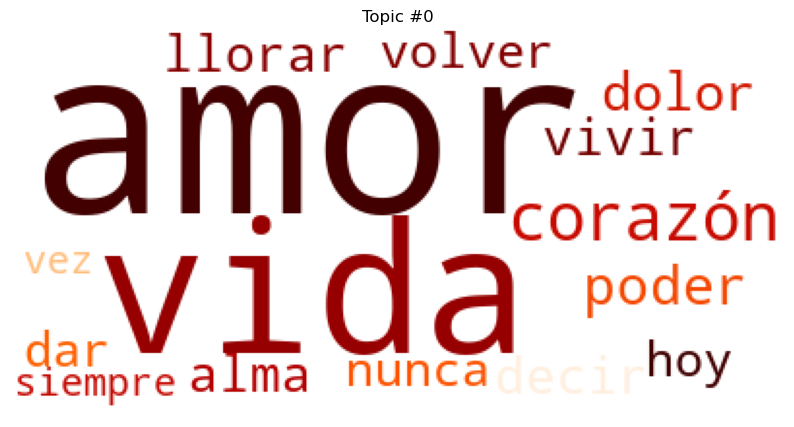

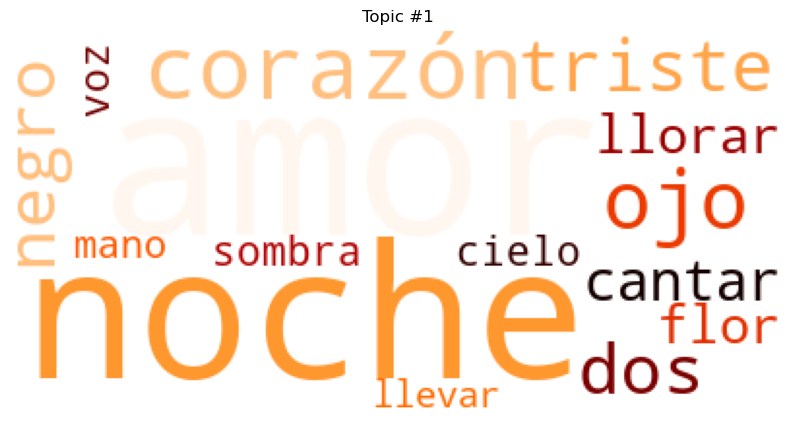

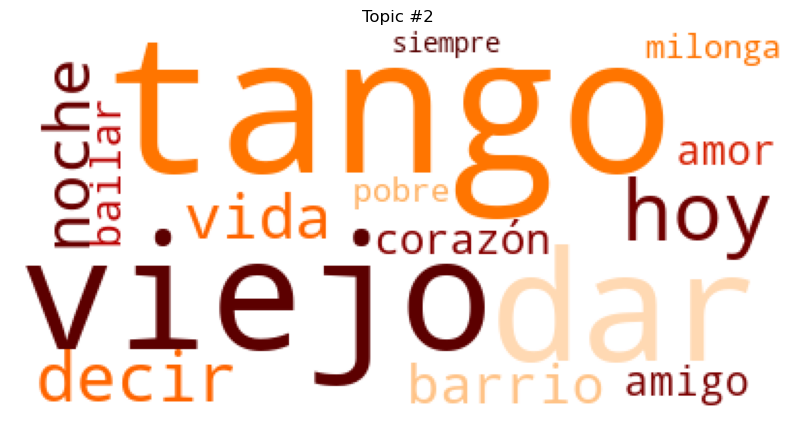

In [89]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

num_words = 15 # Number of words to include in word cloud
for t in range(lda.num_topics):
    plt.figure(figsize=(10,8))
    plt.imshow(WordCloud(background_color ='white', colormap="gist_heat_r").fit_words(dict(lda.show_topic(t, num_words))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

In [329]:
# LDA modelling in that case appeared to be less efficient than LSA and NMF

# KMEANS

In [155]:
doc_topic_df

,SAD LOVE,SUBURB TANGO,TRUE LOVE
0,1.832,0.418,-0.594
1,2.967,-0.688,0.823
2,2.169,-0.003,0.773
3,2.906,-0.301,0.923
4,1.532,1.144,-0.086
...,...,...,...
2466,4.921,0.797,0.934
2467,1.050,0.650,-0.270
2468,1.334,0.297,-1.243
2469,2.602,-0.676,0.394


In [148]:
def get_cluster_centers(X, labels, k_num):
    CC_list = []
    for k in range(k_num):
        # get the mean coordinates of each cluster
        CC_list.append(np.mean(X[labels == k], axis = 0))
    return CC_list

# for each cluster substract the mean from each data point to get the error
# then get the magnitude of each error, square it, and sum it

def get_SSE(X, labels):
    k_num = len(np.unique(labels))
    CC_list = get_cluster_centers(X, labels, k_num)
    CSEs = []
    for k in range(k_num):
        # for each cluster of k we get the coordinates of how far off each point is to the cluster
        error_cords = X[labels == k] - CC_list[k]
        # square the coordinates and sum to get the magnitude squared
        error_cords_sq = error_cords ** 2
        error_mag_sq = np.sum(error_cords_sq, axis = 1)
        # since we already have the magnitude of the error squared we can just take the sum for the cluster
        CSE = np.sum(error_mag_sq)
        CSEs.append(CSE)
    # sum each cluster's sum of squared errors
    return sum(CSEs)

In [149]:

km = KMeans(n_clusters=16) 
km.fit(doc_topic_df)
km.labels_

array([ 5, 13, 13, ...,  5, 13, 10], dtype=int32)

In [152]:
labels = km.labels_

SSEs = []
Sil_coefs = []

for num_clusters in range(2,20):
    km = KMeans(n_clusters=num_clusters) 
    km.fit(doc_topic_df)
    labels = km.labels_
    Sil_coefs.append(silhouette_score(doc_topic_df,labels, metric='cosine'))
    SSEs.append(get_SSE(doc_topic_df, labels)) # The SSE is just inertia, we
                                          # could have just said km.inertia_
Sil_coefs


[0.34178567724567344,
 0.36749259290165287,
 0.1286425047188111,
 0.004715582941246457,
 -0.008221709612960931,
 -0.03227885242924348,
 -0.12016688023416627,
 -0.12456060038368465,
 -0.1399339672474482,
 -0.13620351263357405,
 -0.19703502546453955,
 -0.1546070279595241,
 -0.18713719867874518,
 -0.1941717424988038,
 -0.21054624369164152,
 -0.19767128011539184,
 -0.22948685194537993,
 -0.21136496545648725]

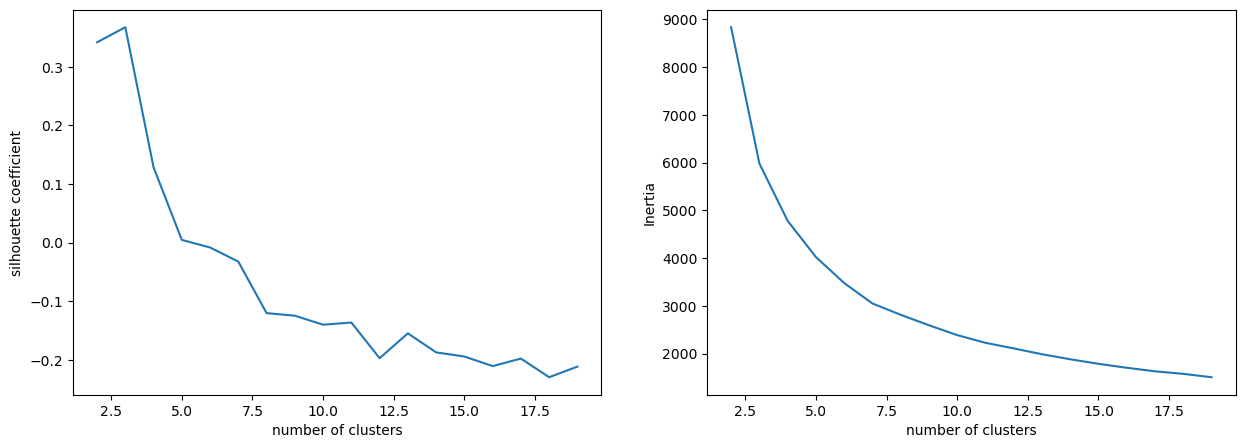

In [153]:
# number of clusters for kmeans
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)
k_clusters = range(2,20)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')

# Sum of Square Error
ax2.plot(k_clusters, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('Inertia');

# Aggreagating LSA model for further EDA

In [515]:
resultLSA # looks like most satisfying model

,AUTHOR,COMPOSER,DATE,LYRICS,ORCHESTRA,SINGER,TITLE,TYPE,WORDS,lemmatized,DRAMATIC ROMANCE,TANGO MUSIC&DANCE,SWEET LOVE,SENTIMET
0,Julio César Curi,Edmundo Baya,1960,tristeza con el vino de mi mesa desataste u...,Rodolfo BIAGI,Hugo Duval,"[Te, burlas, tristeza]",TANGO,124,tristeza con el vino de mi mesa desataste ...,1.832,0.417,-0.583,0.0
1,Alejandro Romay,Roberto Rufino,1959,la casita sobre el lago azul el nido y luz de...,Rodolfo BIAGI,Hugo Duval,"[En, el, lago, azul]",TANGO,80,el casita sobre el lago azul el nido y luz d...,2.967,-0.690,0.843,0.0
2,Lito Bayardo,Juan de Dios Filiberto,1959,flor de mburucuyá abre tu balcón para mi cant...,Rodolfo BIAGI,Hugo Duval,"[La, canción]",TANGO,83,flor de mburucuyá abrir tu balcón para mi ca...,2.169,-0.001,0.762,0.0
3,Oscar Rubens,Alberto Suárez Villanueva,1945,tu melodía siempre la escucho y donde vaya m...,Rodolfo BIAGI,Jorge Ortiz,"[Tu, melodía]",VALS,78,tu melodía siempre él escuchar y donde ir ...,2.906,-0.302,0.919,0.0
4,Alberto Vacarezza,Raúl de los Hoyos,1956,chiche moro zaino vamos pingos por fav...,Rodolfo BIAGI,Hugo Duval,"[El, carrerito]",TANGO,159,chiche moro zaino ir pingo por f...,1.532,1.147,-0.102,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,José Panizza,Edgardo Donato,1959,yo tenía un amorcito que me dejó abandonada y ...,Osvaldo FRESEDO,Blanca Mooney,[Julian],TANGO,171,yo tener uno amorcito que yo dejar abandonado ...,4.921,0.795,0.932,0.0
2467,Miguel Andrés Fama,Miguel Andrés Fama,1939,sos la milonga linda cadenciosa rezongona so...,Edgardo DONATO,Horacio Lagos,"[La, mimada]",MILONGA,74,sos el milonga lindo cadenciós rezongona s...,1.050,0.653,-0.284,0.0
2468,Enrique Dizeo,Anselmo Aieta,1950,qué tipo de suerte que sos mama mía siempre...,Edgardo DONATO,Carlos Almada,"[Qué, fenómeno]",TANGO,152,qué tipo de suerte que sos mama mío siem...,1.334,0.296,-1.236,0.0
2469,Alberto Laureano Martínez,Enrique Santos Discépolo,1960,todo duele en la noche de mi soledad duele ve...,Domingo FEDERICO,Ruben Sanchez y Ruben Maciel,[Andrajos],TANGO,110,todo doler en el noche de mi soledad doler v...,2.602,-0.676,0.393,0.0


# SENTIMENT ANALISYS

In [484]:
from sentiment_analysis_spanish import sentiment_analysis

In [486]:
sentiment = sentiment_analysis.SentimentAnalysisSpanish()
sentiment.sentiment("me gusta la tombola es genial")

0.9304396176531412

In [504]:
resultLSA['SENTIMET'] = df['LYRICS'].apply(lambda x: sentiment.sentiment(x).round(3))

In [512]:
resultLSA['SENTIMET'].unique()

array([0.   , 0.055, 0.207, 0.128, 0.001, 0.023, 0.524, 0.004, 0.003,
       0.157, 0.002, 1.   , 0.92 , 0.27 , 0.005, 0.259, 0.01 , 0.213,
       0.007, 0.478, 0.948])

# EXPORT

In [545]:
#creating reduced table for word cloud
vectorizer = CountVectorizer(stop_words = stops,
                     min_df = .042,
                     ngram_range = (1,1))

In [546]:
doc_term = vectorizer.fit_transform(corpus)

In [548]:
doc_term_df = pd.DataFrame(doc_term.toarray(), columns=vectorizer.get_feature_names_out())
doc_term_df
dv = doc_term_df.T
dv = dv.sum(axis = 1)

abrir      138
adiós      360
ahora      192
alegría    219
alejar     170
          ... 
vivir      800
vivo       130
volver     938
vos        778
voz        629
Length: 239, dtype: int64

In [553]:
dv=dv.reset_index()

In [554]:
dv.to_csv('project5_vis_cloud.csv')

In [519]:
#LSA results export
resultLSA.to_csv('project5_vis.csv')